In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import torch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(tickers=[ticker], start=start_date, end=end_date, interval="1d")
    data['Pct Change'] = data['Close'].pct_change() * 100
    data = data.dropna()
    data.drop(columns=['High', 'Low', 'Adj Close'], inplace =True)
    data.reset_index(inplace=True)
    
#     plt.figure(figsize=(9,6))
#     plt.plot(data['Date'], data['Close'])
#     plt.title(f"Daily {ticker} Price", fontsize=16)
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Price', fontsize=14)
#     plt.grid(True)
#     plt.show()
    
    plt.figure(figsize=(9,6))
    plt.plot(data['Date'], data['Pct Change'])
    plt.title(f"Daily {ticker} Percentage Change", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage Change', fontsize=14)
    plt.grid(True)
    plt.show()
    return data

def get_index(data, date):
    return data[data['Date'] == date].index[0]


def plot_autocorr(data, lag):
    fig, ax = plt.subplots(figsize=(9, 6))
    plot_acf(data, lags=lag, zero=False, ax=ax)
    return 

def moving_block_bootstrap(data, block_length, num_samples):
    num_obs = len(data)
    output = []
    for i in range(int(num_samples//block_length)):
        start_index = np.random.randint(0, num_obs - block_length + 1)
        output = output + (list(data[start_index:start_index+block_length]))
    return np.array(output)

def construct_price_from_pct(pct_array, initial_value):
    price = np.zeros(len(pct_array)+1)
    price[0] = initial_value
    for i in range(1, len(pct_array)+1):
        price[i] = price[i-1]*(1+pct_array[i-1]/100)
    return price

def MSE_calculation(data, start_idx, end_idx, col0, *cols):
    df = data.iloc[start_idx:end_idx]
    MSE = np.zeros(len(cols))
    for i, col in enumerate(cols):
        MSE[i] = np.mean((df[col0]-df[col])**2)
        
    plt.figure(figsize=(12,6))
    plt.bar(cols, MSE)
    plt.title("MSE by Models")
    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Mean Square Error', fontsize=14)
    plt.grid(True)
    plt.show()
    return MSE


def month_MSE(data, start_month, end_month, col0, *cols):
    month_range = pd.date_range(start=start_month, end=end_month, freq='MS')
    MSE = np.zeros((len(month_range),len(cols)))
    start_year = int(start_month[:4]) 
    for j in range(len(cols)):
        for i in range(len(month_range)):
            df = data[(data['Date'].dt.year == start_year+i//12) & (data['Date'].dt.month == i%12+1)]
            MSE[i,j] = np.mean((df[col0]-df[cols[j]])**2)
    
    plt.figure(figsize=(12,6))
    for j in range(len(cols)):
        plt.plot(month_range, MSE[:,j], marker='o', label=cols[j])
    plt.title('MSE of Prediction', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Square Error', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return MSE

def ARIMA_windowsliding(data, window_size, col_val, col_chg, p, d, q, start, end):
    pct_prediction = np.zeros(len(data))
    price_prediction = np.zeros(len(data))
    for i in range(start, end):
        df = data.iloc[i-window_size+1:i+1]
        x = df[col_chg]
        model = ARIMA(x, order=(p, d, q))
        model_fit = model.fit()
        pct_prediction[i] = model_fit.forecast(steps=1)
        price_prediction[i] = (1+pct_prediction[i]/100) * data.iloc[i-1][col_val]
    return pct_prediction, price_prediction


def ARIMA_windowsliding_MBB(data, window_size, col_val, col_chg, p, d, q, start, end, num_MBB):
    pct_prediction = np.zeros(len(data))
    price_prediction = np.zeros(len(data))
    for i in range(start, end):
        df = data.iloc[i-window_size+1:i+1]
        x = np.array(df[col_chg])
        x_MBB = moving_block_bootstrap(x, int(window_size/10), num_MBB)
        x = np.concatenate((x, x_MBB))
        model = ARIMA(x, order=(p, d, q))
        model_fit = model.fit()
        pct_prediction[i] = model_fit.forecast(steps=1)
        price_prediction[i] = (1+pct_prediction[i]/100) * data.iloc[i-1][col_val]
    return pct_prediction, price_prediction

def train_ARIMA(x, order):
    model = ARIMA(x, order=order)
    model_fit = model.fit()
    return model_fit

def predict_ARIMA(data, window_size, col_val, col_chg, order, start, end, model_trained):
    pct_prediction = np.zeros(len(data))
    price_prediction = np.zeros(len(data))
    for i in range(start, end):
        df = data.iloc[i-window_size+1:i+1]
        x = df[col_chg]
        model = ARIMA(x, order=order)
        model_fit = model.fit()
        model_fit.arparams = model_trained.arparams
        print(model_fit.arparams)
        print(model_fit.summary())
        pct_prediction[i] = model_fit.forecast(steps=1)
        price_prediction[i] = (1+pct_prediction[i]/100) * data.iloc[i-1][col_val]
    return pct_prediction, price_prediction

[*********************100%***********************]  1 of 1 completed


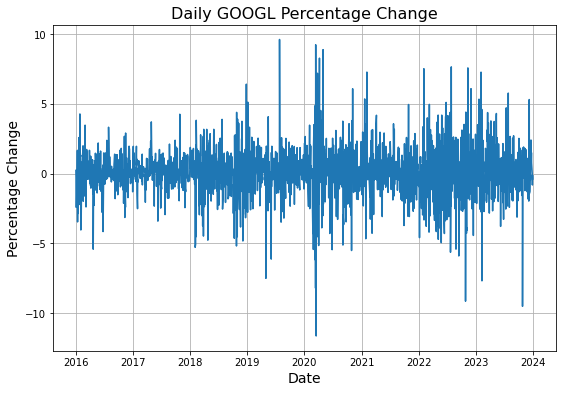

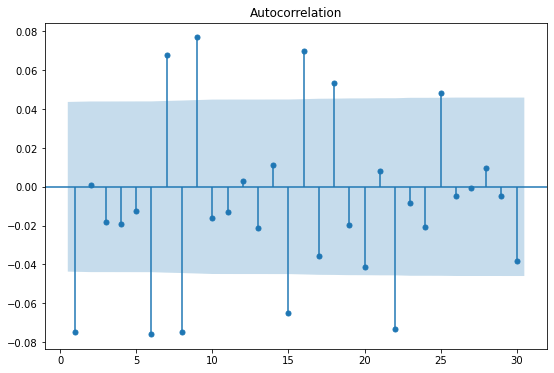

In [415]:
googl = load_stock_data('GOOGL', '2015-12-31', '2023-12-31')
plot_autocorr(googl['Pct Change'], 30)
i2017 = get_index(google, '2017-01-03')
i2019 = get_index(google, '2019-01-02')
i2020 = get_index(google, '2020-01-02')
i2021 = get_index(google, '2021-01-04')
i2022 = get_index(google, '2022-01-03')
i2023 = get_index(google, '2023-01-03')

In [444]:
def predict_ARIMA(data, p, col_val, col_chg, start, end, model_trained):
    pct_prediction = np.zeros(len(data))
    price_prediction = np.zeros(len(data))
    params = np.array(model_trained.arparams)
    print(params)
    for i in range(start, end):
        df = data.iloc[i-p:i]
        x = np.array(df[col_chg])
        pct_prediction[i] = np.dot(params, x)
        price_prediction[i] = (1+pct_prediction[i]/100) * data.iloc[i-1][col_val]
    return pct_prediction, price_prediction


data_train_real = googl.iloc[0:i2019]['Pct Change']
ARIMA_model_real = train_ARIMA(data_train_real, (5,0,0))
googl['ARIMA Pct'], googl['ARIMA Price'] = predict_ARIMA(googl, 5, 'Close', 'Pct Change', i2019, i2020, ARIMA_model_real)

pro
data_train_MBB = moving_block_bootstrap(data_train_real, 10, len(data_train_real)*0)
data_train = np.concatenate((data_train_real, data_train_MBB))
ARIMA_model_MBB = train_ARIMA(data_train, (5,0,0))
googl['ARIMA Pct MBB'], googl['ARIMA Price MBB'] = predict_ARIMA(googl, 5, 'Close', 'Pct Change', i2019, i2020, ARIMA_model_MBB)

[ 0.00779495 -0.02764476  0.03477192 -0.01928479 -0.0593757 ]
[ 0.00779495 -0.02764476  0.03477192 -0.01928479 -0.0593757 ]


In [445]:
len(data_train)

754

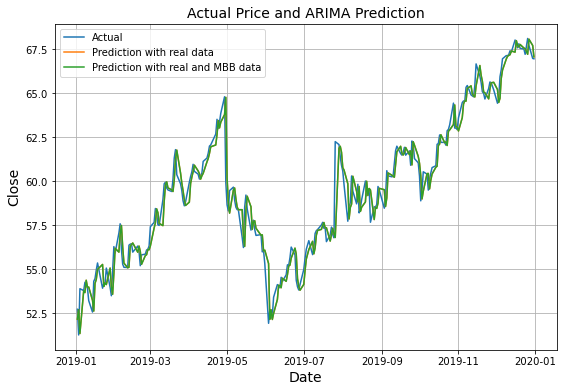

In [446]:
plt.figure(figsize=(9,6))
plt.plot(googl.iloc[i2019:i2020]['Date'], googl.iloc[i2019:i2020]['Close'], label='Actual')
plt.plot(googl.iloc[i2019:i2020]['Date'], googl.iloc[i2019:i2020]['ARIMA Price'], label='Prediction with real data')
plt.plot(googl.iloc[i2019:i2020]['Date'], googl.iloc[i2019:i2020]['ARIMA Price MBB'], label='Prediction with real and MBB data')
plt.title('Actual Price and ARIMA Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

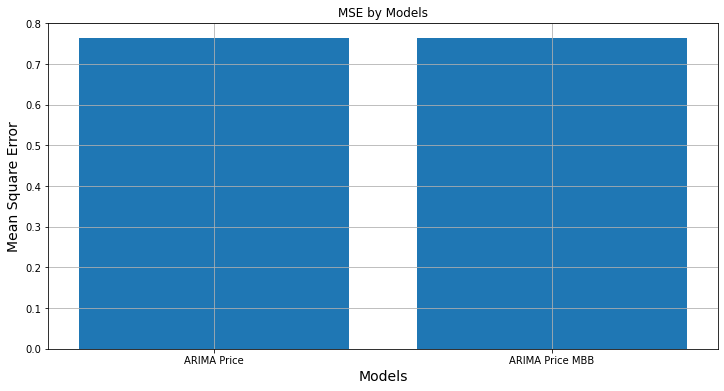

[0.76371309 0.76371309]


In [447]:
print(MSE_calculation(googl, i2019, i2020, 'Close', 'ARIMA Price', 'ARIMA Price MBB'))

In [406]:
googl

,Date,Open,Close,Volume,Pct Change,ARIMA Pct,ARIMA Price,ARIMA Pct MBB,ARIMA Price MBB
0,2016-01-04,38.110001,37.972000,67382000,-2.386862,0.000000,0.000000,0.000000,0.000000
1,2016-01-05,38.205002,38.076500,45216000,0.275202,0.000000,0.000000,0.000000,0.000000
2,2016-01-06,37.518501,37.966499,48206000,-0.288894,0.000000,0.000000,0.000000,0.000000
3,2016-01-07,37.324501,37.049999,63132000,-2.413970,0.000000,0.000000,0.000000,0.000000
4,2016-01-08,37.389999,36.545502,47506000,-1.361667,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2007,2023-12-22,140.770004,141.490005,26514600,0.762005,-0.358417,139.916709,-0.358417,139.916709
2008,2023-12-26,141.589996,141.520004,16780300,0.021202,-0.158018,141.266426,-0.158018,141.266426
2009,2023-12-27,141.589996,140.369995,19628600,-0.812612,-0.330278,141.052595,-0.330278,141.052595
2010,2023-12-28,140.779999,140.229996,16045700,-0.099736,0.084300,140.488327,0.084300,140.488327


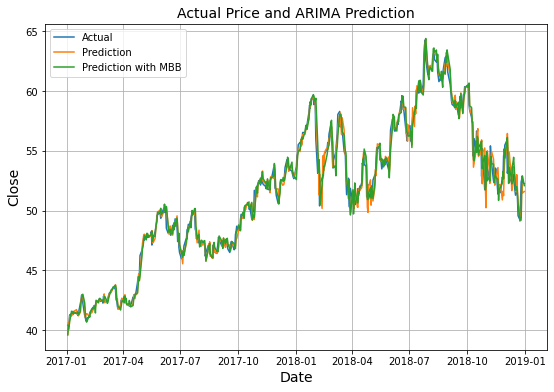

In [344]:
plt.figure(figsize=(9,6))
plt.plot(googl.iloc[i2017:i2019]['Date'], googl.iloc[i2017:i2019]['Close'], label='Actual')
plt.plot(googl.iloc[i2017:i2019]['Date'], googl.iloc[i2017:i2019]['ARIMA Price'], label='Prediction')
plt.plot(googl.iloc[i2017:i2019]['Date'], googl.iloc[i2017:i2019]['ARIMA MBB Price'], label='Prediction with MBB')
plt.title('Actual Price and ARIMA Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
googl['ARIMA Price2'] =  ARIMA_window_sliding(googl, 30, 5, 1, 0, 'Pct Change', i2017, i2019)
pct_array = np.array(googl.iloc[i2017:i2019]['ARIMA Pct Change'])
predicted = construct_price_from_pct(pct_array, googl.iloc[i2017-1]['Close'])
price_prediction = np.zeros(len(googl))
price_prediction[i2017-1:i2019] = predicted
googl['ARIMA Price'] = price_prediction

plt.figure(figsize=(9,6))
plt.plot(googl.iloc[idx2017:idx2019]['Date'], googl.iloc[idx2017:idx2019]['Close'], label='Actual')
plt.plot(googl.iloc[idx2017:idx2019]['Date'], googl.iloc[idx2017:idx2019]['ARIMA Price'], label='Prediction')
plt.title('Actual Close and Autoregressive Lag1 Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

[-0.06712543 -0.00454031 -0.02152883 -0.01556887 -0.05420822 -0.01856275
  0.08857354 -0.02851804  0.05227411 -0.0153337  -0.01464386  0.05050051
 -0.05261118  0.03742128 -0.00793018  0.09805178 -0.00097856  0.05259433
 -0.04858127 -0.02686847]


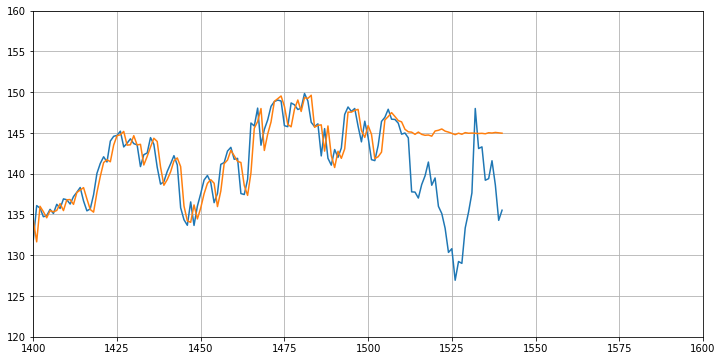

In [369]:
x = googl['Close']
x_train = x[:idx2022]
model = ARIMA(x_train, order=(20, 1, 0))
model_fit = model.fit()

print(model_fit.arparams)

start_index = idx2022-30
end_index = idx2022+30
x_hat = model_fit.predict()
x_hat2 = model_fit.forecast(steps=30)
x_hat = np.concatenate((x_hat, x_hat2))

plt.figure(figsize=(12,6))
plt.plot(x[:end_index])
plt.plot(x_hat)
plt.xlim(1400,1600)
plt.ylim(120,160)
plt.grid(True)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2351.359
Date:                Mon, 26 Feb 2024   AIC                           4724.717
Time:                        13:13:17   BIC                           4783.236
Sample:                             0   HQIC                          4746.510
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0778      0.018     -4.268      0.000      -0.114      -0.042
ar.L2          0.0052      0.018      0.295      0.768      -0.029       0.040
ar.L3         -0.0295      0.017     -1.765      0.0

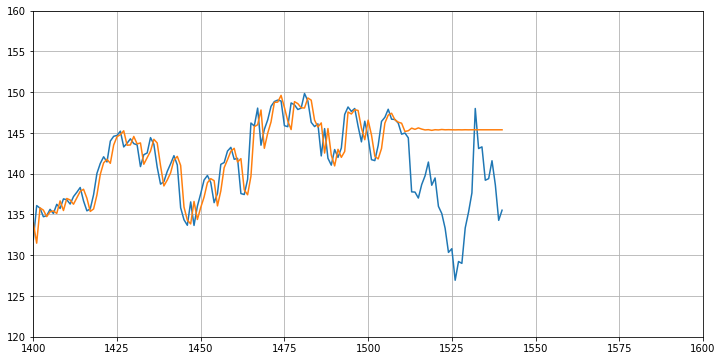

In [210]:
x = google['Pct Change']
x_train = x[:idx2022]
model = ARIMA(x_train, order=(10, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

start_index = idx2022-30
end_index = idx2022+30
x_hat = model_fit.predict()
x_hat2 = model_fit.forecast(steps=30)
x_hat = np.concatenate((x_hat, x_hat2))

plt.figure(figsize=(12,6))
plt.plot(x[:end_index])
plt.plot(x_hat)
plt.xlim(1400,1600)
plt.ylim(120,160)
plt.grid(True)

                               SARIMAX Results                                
Dep. Variable:             Pct Change   No. Observations:                 1511
Model:                ARIMA(10, 0, 0)   Log Likelihood               -2851.466
Date:                Mon, 26 Feb 2024   AIC                           5726.932
Time:                        13:14:44   BIC                           5790.778
Sample:                             0   HQIC                          5750.708
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1013      0.038      2.695      0.007       0.028       0.175
ar.L1         -0.0912      0.020     -4.610      0.000      -0.130      -0.052
ar.L2         -0.0050      0.019     -0.260      0.7

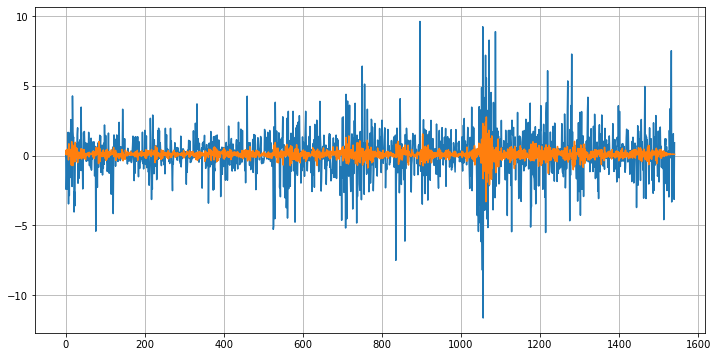

In [213]:
from statsmodels.tsa.arima.model import ARIMA

x = google['Pct Change']
x_train = x[:idx2022]
model = ARIMA(x_train, order=(10, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

start_index = idx2022-30
end_index = idx2022+30
x_hat = model_fit.predict()
x_hat2 = model_fit.forecast(steps=30)
x_hat = np.concatenate((x_hat, x_hat2))

plt.figure(figsize=(12,6))
plt.plot(x[:end_index])
plt.plot(x_hat)
plt.xlim(1400,1600)
plt.ylim(120,160)
plt.grid(True)

In [359]:
from statsmodels.tsa.arima.model import ARIMA

# Define the data lists
A = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
B = [10, 11, 12, 13, 14, 15]

# Train the ARIMA model (likely overfitting in this scenario)
model = ARIMA(A, order=(1, 0, 0))  # Assuming order (1, 0, 0) 
model_fit = model.fit()

# Predict the next element in B
prediction = model_fit.forecast(steps=1)[0]
print("Predicted next element in B:", prediction) 

Predicted next element in B: 9.870025062806228
